In [1]:
# Importation des modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import typing as tp
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# Variables globales
random_state: int = 42

In [2]:
def plot_1d(features: tp.Any, target: tp.Any) -> None:
	"""
	Réduit un DataFrame à une seule dimension en utilisant SVD et trace deux KDE plots en fonction des labels.

	Args:
		dataframe (Any): Les features à utiliser.
		labels (Any): Les labels correspondants aux features.

	Returns:
		None
	"""
	# Réduire le DataFrame à une dimension en utilisant SVD
	svd = TruncatedSVD(n_components=1, random_state=random_state)
	df_1d = svd.fit_transform(features)

	# Créez un DataFrame à partir de la réduction à une dimension et des labels
	df_1d = pd.DataFrame(data=df_1d, columns=['Dimension 1'])
	df_1d['Labels'] = target.reset_index(drop=True)

	# Tracez deux KDE plots en fonction des labels
	plt.figure(figsize=(12, 8))  # Ajustez la taille du plot si nécessaire
	sns.kdeplot(data=df_1d[df_1d['Labels'] == 0]['Dimension 1'], label='fakes', shade=True)
	sns.kdeplot(data=df_1d[df_1d['Labels'] == 1]['Dimension 1'], label='Reals', shade=True)
	plt.title("KDE Plot - Dimension 1")
	plt.xlabel("Valeur")
	plt.ylabel("Densité")
	plt.legend()
	plt.show()

In [3]:
def plot_2d(X: tp.Any, y: tp.Any, method: str='svd') -> None:
	"""
	Effectue une analyse de réduction de dimension sur les données et génère un scatterplot avec légende.

	Cette fonction prend des données X et une série d'étiquettes y, effectue une réduction de dimension
	en 2 dimensions en utilisant SVD, et affiche un scatterplot coloré en fonction des étiquettes.

	Args:
		X (Any): Les données à utiliser pour la réduction de dimension.
		y (Any): Les étiquettes correspondantes.
		method (str, optional): La méthode de réduction de dimension à utiliser ('svd'). Par défaut, 'svd'.

	Returns:
		None
	"""
	
	# Réduction de dimension en utilisant SVD
	if method == "svd":
		reduction_result = TruncatedSVD(n_components=2, random_state=random_state).fit_transform(X)
	else:
		raise ValueError("La méthode spécifiée doit être 'pca' ou 'tsne'.")

	# Extraction des coordonnées x et z
	x = [i for i, j in reduction_result]
	z = [j for i, j in reduction_result]

	# Détermination des couleurs en fonction des étiquettes
	colors: tp.List[str] = ["blue" if label == 0 else "red" for label in y.tolist()]

	# Affichage du scatterplot avec légende
	plt.figure(figsize=(12, 8))
	for label, color in {"fakes": "blue", "reals": "red"}.items():
		plt.scatter([], [], c=color, label=label)
	plt.scatter(x, z, c=colors, marker='o', edgecolors="black")
	plt.xlabel("Features 1")
	plt.ylabel("Features 2")
	plt.legend(loc='best')
	plt.show()

In [4]:
def plot_top_n_words(df: pd.DataFrame, column_name: str, n: int=10) -> None:
    """
    Crée un graphique à barres montrant les n mots les plus courants dans une colonne donnée d'un DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données.
        column_name (str): Le nom de la colonne à analyser.
        n (int, optional): Le nombre de mots les plus courants à afficher. Par défaut, 10.

    Returns:
        None
    """
    # Comptez l'occurrence des mots
    most_freqWords = defaultdict(int)
    for sentence in df[column_name].tolist():
        for word in sentence.split(sep=' '):
            most_freqWords[word] += 1

    # Triez les mots par fréquence décroissante
    most_freqWords = sorted(most_freqWords.items(), key=lambda item: (-item[1], item[0]))

    # Sélectionnez les n mots les plus courants
    top_n_words = most_freqWords[:n]

    # Séparez les mots et leurs fréquences
    words, frequencies = zip(*top_n_words)

    # Créez un graphique à barres
    plt.figure(figsize=(12, 6))
    plt.bar(range(n), frequencies, tick_label=words)
    plt.xlabel('Mots')
    plt.ylabel('Fréquence')
    plt.title(f'{n} Mots les plus courants')
    plt.xticks(rotation=45, ha="right")  # Pour faire pivoter les étiquettes des mots
    plt.tight_layout()

    # Affichez le graphique
    plt.show()

In [5]:
def balance_classes(df: pd.DataFrame, class_column: str) -> pd.DataFrame:
    """
    Équilibre les classes d'un DataFrame en supprimant les éléments excédentaires de la classe majoritaire.

    Parameters:
        df (pd.DataFrame): Le DataFrame contenant les données.
        class_column (str): Le nom de la colonne de classe.

    Returns:
        pd.DataFrame: Le DataFrame équilibré avec le même nombre d'éléments pour chaque classe.
    """
    # Compter le nombre d'éléments dans chaque classe
    counts = df[class_column].value_counts()

    # Identifier la classe majoritaire et minoritaire
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()

    # Nombre d'éléments dans la classe majoritaire et minoritaire
    majority_count = counts[majority_class]
    minority_count = counts[minority_class]

    # Si la classe minoritaire a moins d'éléments que la classe majoritaire
    if minority_count < majority_count:
        # Sélectionner uniquement les éléments de la classe majoritaire
        majority_data = df[df[class_column] == majority_class].copy()

        # Échantillon aléatoirement la classe majoritaire pour qu'elle ait le même nombre d'éléments que la classe minoritaire
        majority_data = majority_data.sample(n=minority_count, random_state=random_state)

        # Sélectionner tous les éléments de la classe minoritaire
        minority_data = df[df[class_column] == minority_class].copy()

        # Concaténer les deux classes équilibrées
        balanced_df = pd.concat([majority_data, minority_data], axis=0).reset_index(drop=True)

        return balanced_df

    # Sinon, si les classes ont déjà le même nombre d'éléments, pas besoin de rééchantillonner
    else:
        return df.copy()

In [6]:
def plot_top_features(importances: np.ndarray, feature_names: list, n: int = 10) -> None :
    """
    Trace un barplot des caractéristiques les plus importantes.

    Args:
        importances (np.ndarray): Tableau des importances des caractéristiques.
        feature_names (list): Liste des noms des caractéristiques.
        n (int, optional): Nombre de caractéristiques à afficher. Par défaut, 10.

    Returns:
        None: La fonction affiche le graphique.

    Exemple d'utilisation :
    plot_top_features(importances, feature_names, n=10)
    """
    # Triez les caractéristiques par importance
    indices = importances.argsort()[::-1][:n]
    top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]

    # Créez le barplot
    plt.figure(figsize=(12, 8))
    plt.bar(range(n), top_importances, align='center')
    plt.xticks(range(n), top_features, rotation=45, ha='right')
    plt.xlabel('Caractéristiques')
    plt.ylabel('Importance')
    plt.title(f'Top {n} Caractéristiques Importantes')
    plt.tight_layout()
    plt.show()

In [7]:
def plot_confusion_matrix(y_true: tp.Any, y_pred: tp.Any) -> None:
	"""
	Affiche une matrice de confusion sous forme de heatmap.

	Args:
		y_true (Any): Les vraies étiquettes.
		y_pred (Any): Les étiquettes prédites.

	Returns:
		None
	"""
	# Calculer la matrice de confusion
	conf_matrix = confusion_matrix(y_true, y_pred)

	# Créer un heatmap de la matrice de confusion
	plt.figure(figsize=(12, 8))
	sns.set(font_scale=1.2)  # Réglez la taille de la police
	sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
				xticklabels=['fakes', 'reals'], yticklabels=['fakes', 'reals'])
	plt.xlabel('Prédictions')
	plt.ylabel('Réalités')
	plt.title('Matrice de Confusion')
	plt.show()

def plot_roc_auc(y_true: tp.Any, y_pred: tp.Any) -> None:
	"""
	Affiche la courbe ROC (Receiver Operating Characteristic) avec l'AUC (Area Under the Curve).

	Args:
		y_true (Any): Les vraies étiquettes.
		y_pred (Any): Les scores prédits (probabilités).

	Returns:
		None
	"""
	# Calculer la courbe ROC et l'AUC
	fpr, tpr, thresholds = roc_curve(y_true, y_pred)
	roc_auc = roc_auc_score(y_true, y_pred)

	# Tracer la courbe ROC
	plt.figure(figsize=(12, 8))
	plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Courbe ROC (AUC = {roc_auc:0.2f})")
	plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('Taux de Faux Positifs (FPR)')
	plt.ylabel('Taux de Vrais Positifs (TPR)')
	plt.title('Courbe ROC')
	plt.legend(loc='lower right')
	plt.show()

def evaluate_classification(y_true: tp.Any, y_pred: tp.Any) -> None :
    """
    Évalue la classification en affichant un rapport de classification, une matrice de confusion
    et une courbe ROC AUC.

    Args:
        y_true (array-like): Les vraies étiquettes de classe.
        y_pred (array-like): Les étiquettes de classe prédites.

    Returns:
        None
    """
    # Affiche le rapport de classification
    print(f"Rapport de classification :\n\n{classification_report(y_true, y_pred)}")

    # Affiche la matrice de confusion
    plot_confusion_matrix(y_true, y_pred)

    # Affiche la courbe ROC AUC
    plot_roc_auc(y_true, y_pred)

# Préparation des données

In [8]:
# Initialiser les données
data = pd.read_csv("./fakesNews_dataset.csv")

# Choisir l'un des subsets des fakes news (ici le subset 1)
data = data[(data["labels"] == 0) | (data["labels"] == 3)]

# Changer les labels
data["labels"] = data["labels"].apply(lambda x: 1 if x == 3 else 0)

# Équilibrer les classes
data = balance_classes(data, "labels")

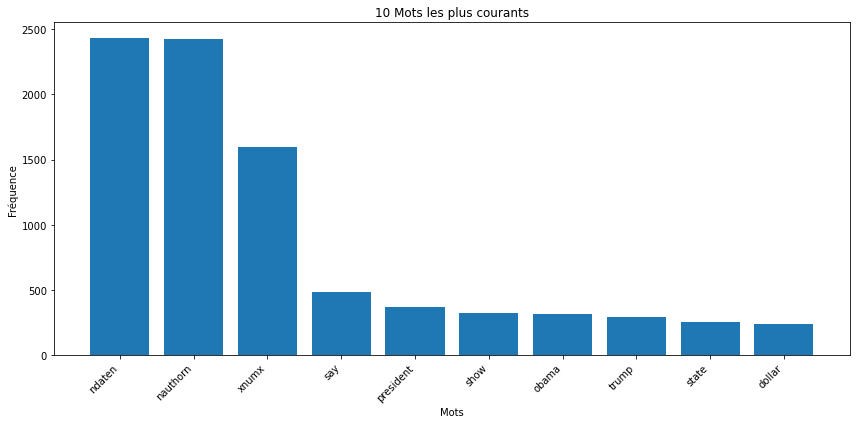

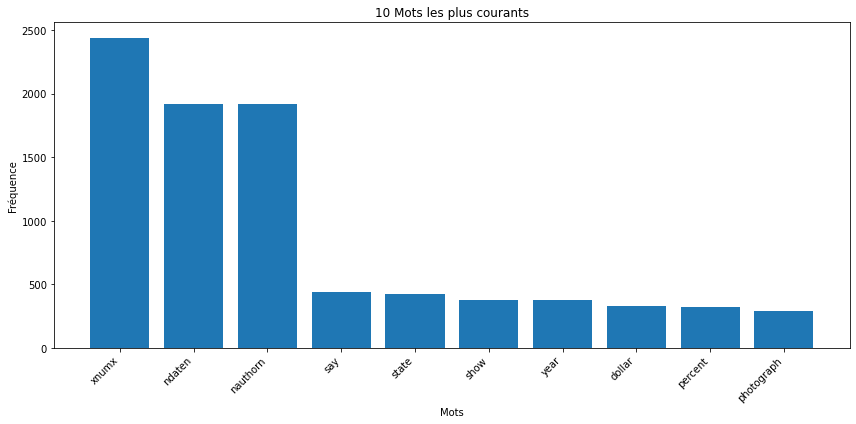

In [9]:
# Afficher les n 10 mode les plus fréquents, pour voir s'il y a une différence entre les fakes et les reals news
for i in [0, 1] :
    choice = data[data["labels"] == i]
    plot_top_n_words(choice, "features", 10)

# Sélection des variables

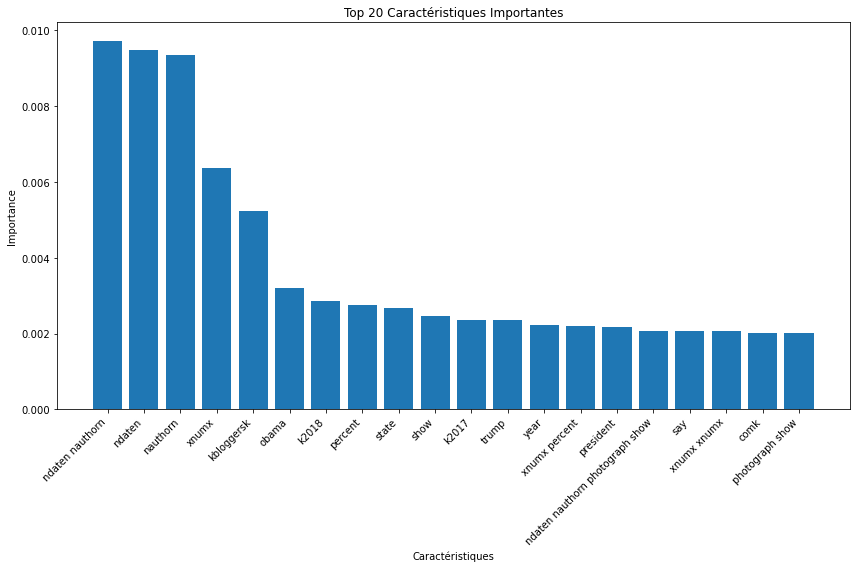

In [10]:
# Séparation des features et labels
features, labels = data["features"], data["labels"]

# Splitting en train et test sets
X, x_test, y, y_test = train_test_split(features, labels, stratify=labels, random_state=random_state, test_size=1000)

# Vectorisation des features
vectorizer = TfidfVectorizer(min_df=2, max_df=0.80, ngram_range=(1, 5)).fit(X)
X_trans, x_test_trans = vectorizer.transform(X), vectorizer.transform(x_test)

# Selection des variables
estimator = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=random_state).fit(X_trans, y)
selector = SelectFromModel(estimator=estimator, max_features=5000).fit(X_trans, y) 
X_trans, x_test_trans = selector.transform(X_trans), selector.transform(x_test_trans)

# Visualisation des meilleurs features
plot_top_features(importances=estimator.feature_importances_, feature_names=vectorizer.get_feature_names_out(), n=20)

(7248, 3750)
0    3624
1    3624
Name: labels, dtype: int64


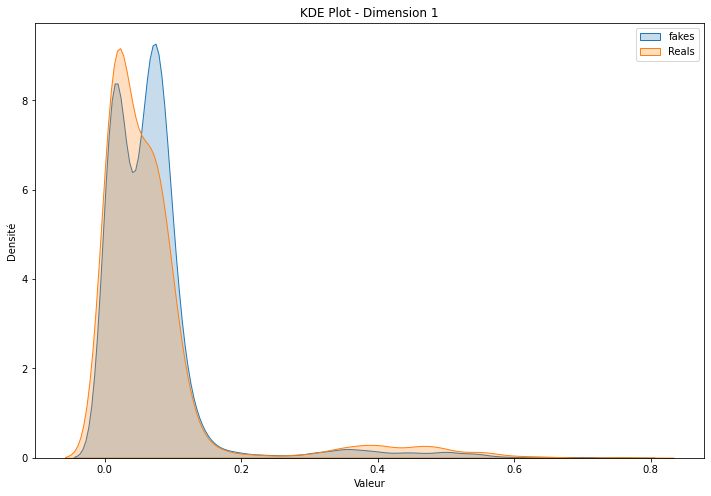

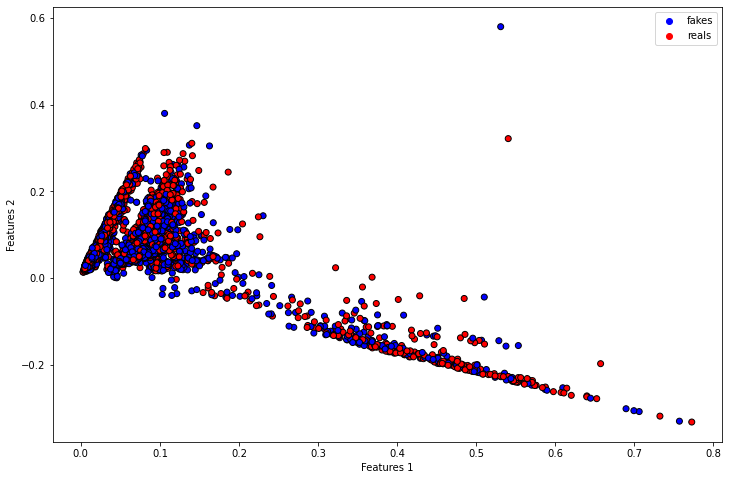

In [11]:
# Vérifier l'état du trainset
print(X_trans.shape)
print(y.value_counts())
plot_1d(X_trans, y)
plot_2d(X_trans, y)

(1000, 3750)
1    500
0    500
Name: labels, dtype: int64


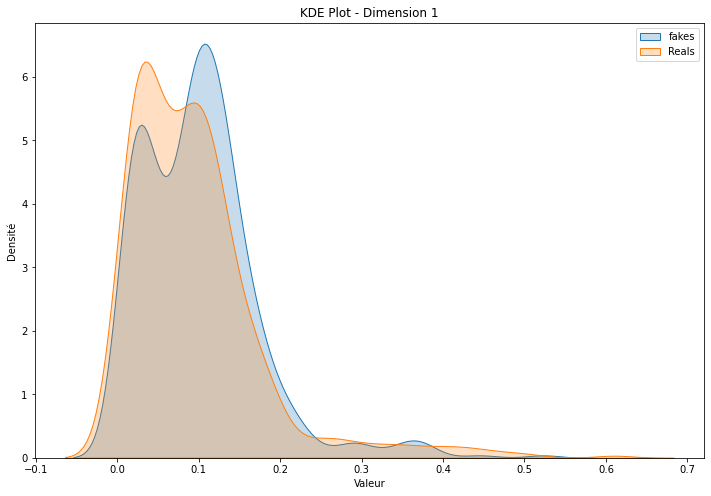

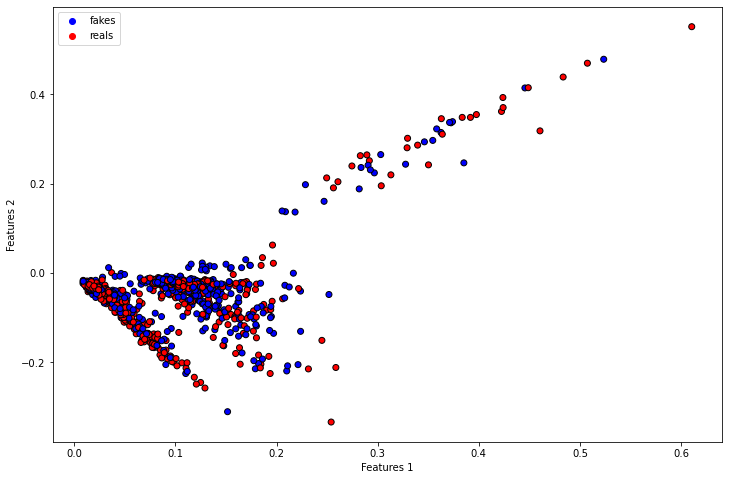

In [12]:
# Vérifier l'état du testset
print(x_test_trans.shape)
print(y_test.value_counts())
plot_1d(x_test_trans, y_test)
plot_2d(x_test_trans, y_test)

# Entrainements et évaluations

Rapport de classification :

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       500
           1       0.68      0.62      0.65       500

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



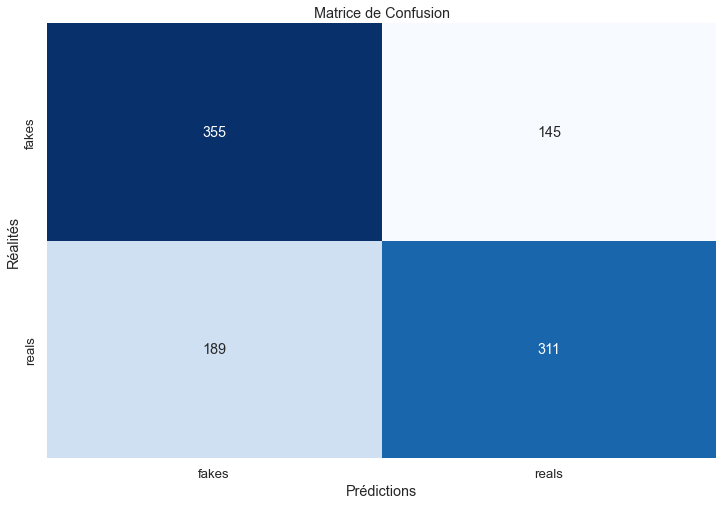

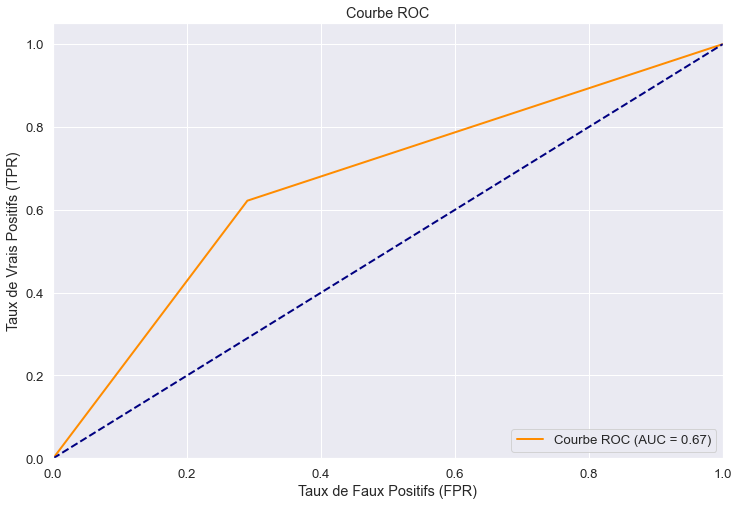

Rapport de classification :

              precision    recall  f1-score   support

           0       0.64      0.73      0.68       500
           1       0.69      0.59      0.63       500

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000



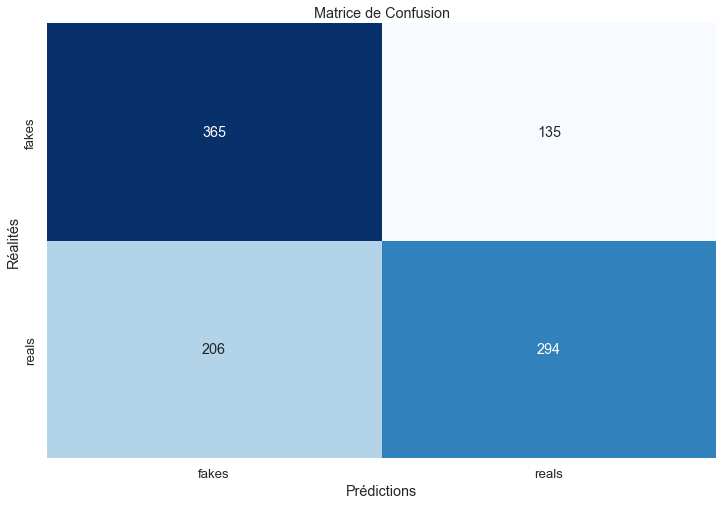

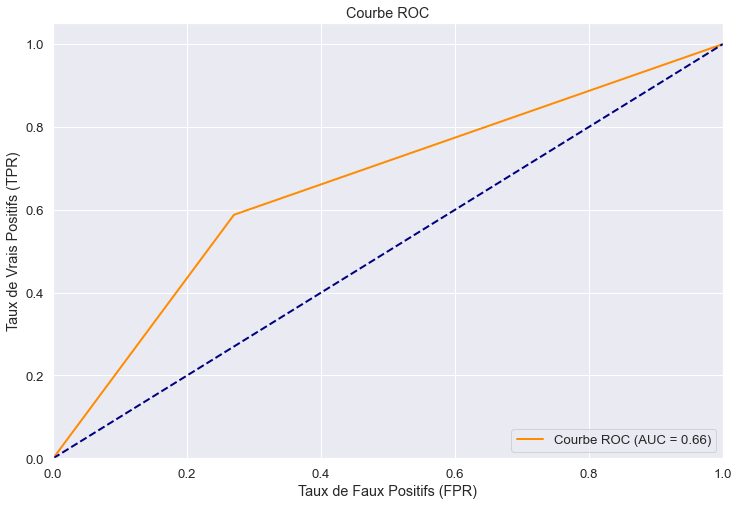

Rapport de classification :

              precision    recall  f1-score   support

           0       0.65      0.68      0.66       500
           1       0.66      0.63      0.65       500

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.65      1000
weighted avg       0.66      0.66      0.65      1000



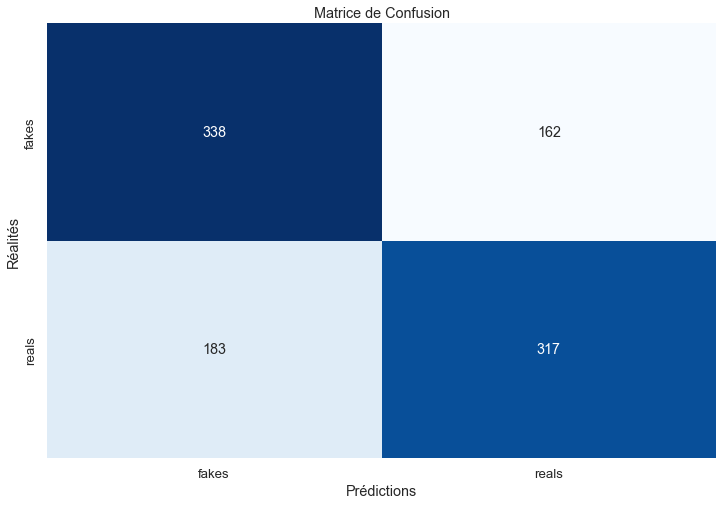

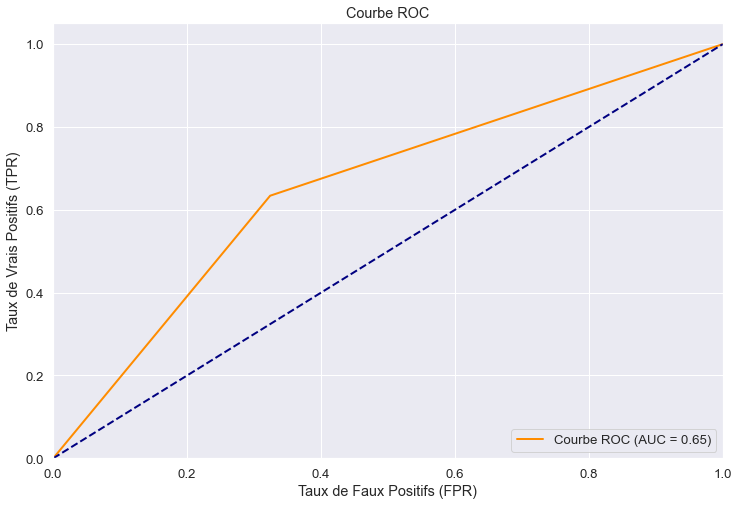

Rapport de classification :

              precision    recall  f1-score   support

           0       0.63      0.71      0.67       500
           1       0.67      0.59      0.63       500

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000



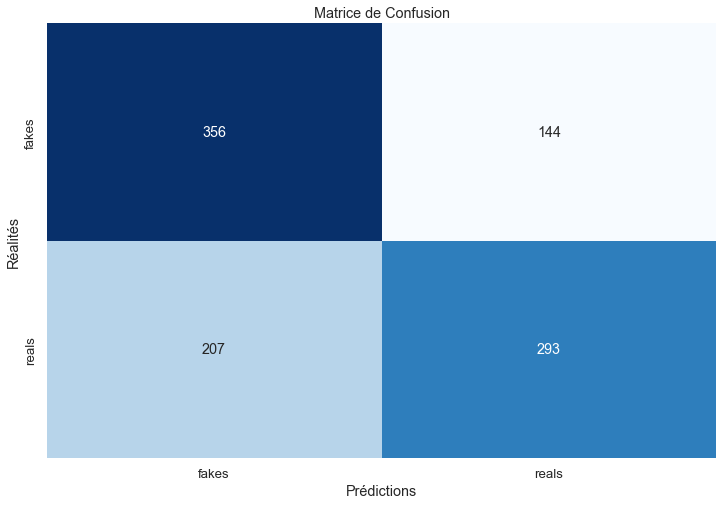

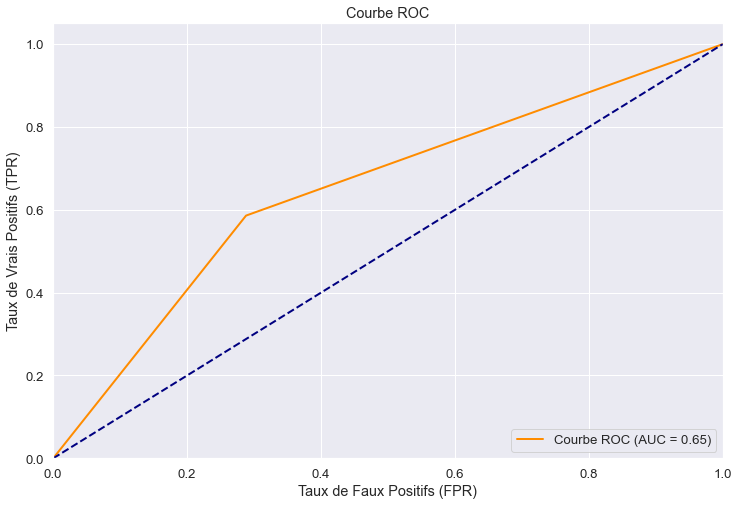

Rapport de classification :

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       500
           1       0.71      0.61      0.65       500

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.68      0.68      0.68      1000



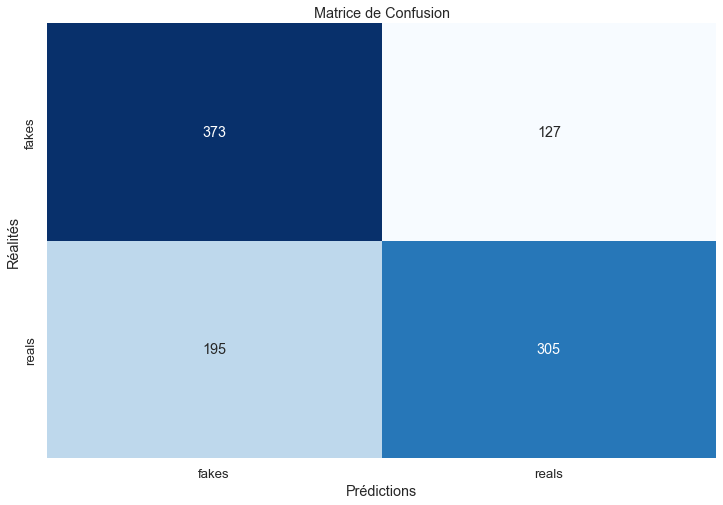

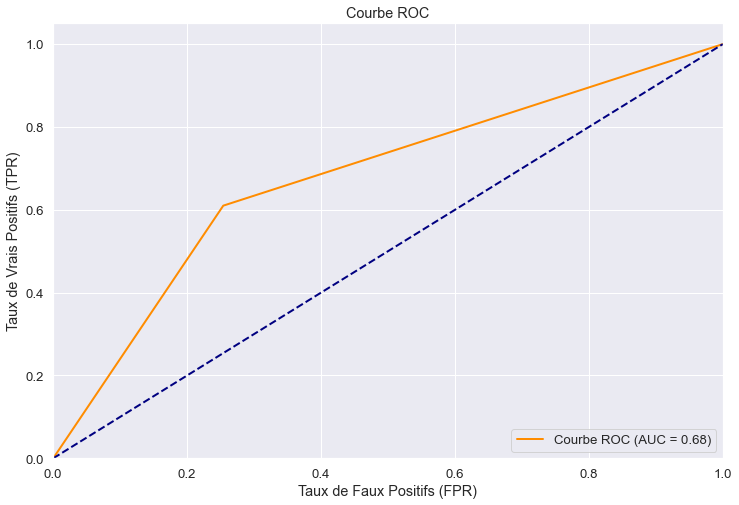

Rapport de classification :

              precision    recall  f1-score   support

           0       0.69      0.64      0.66       500
           1       0.66      0.71      0.68       500

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



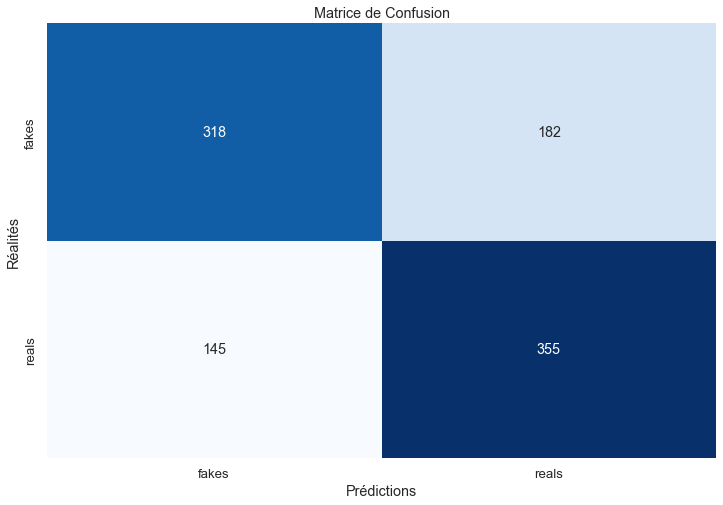

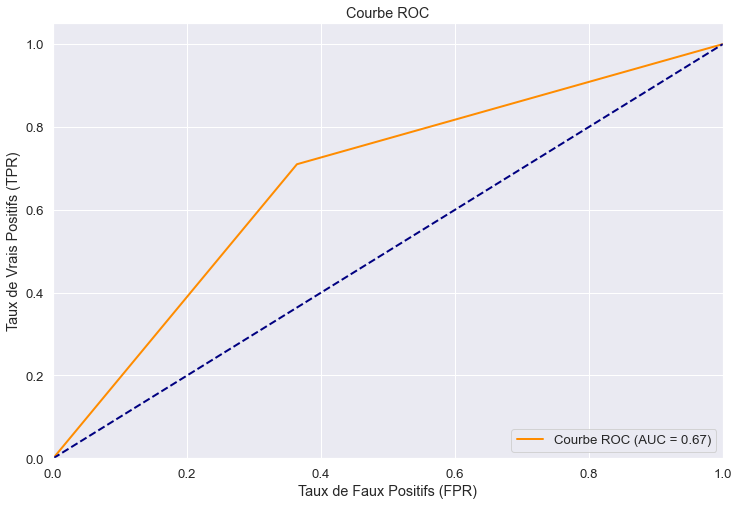

In [13]:
# Liste des modèels à tester
models = [LogisticRegression(random_state=random_state),
          BernoulliNB(),
          MultinomialNB(),
          XGBClassifier(random_state=random_state),
          RandomForestClassifier(random_state=random_state),
          SVC(random_state=random_state, probability=True)]

for model in models :
    # Dictionnaires de modèles à tester
    model.fit(X_trans, y)
    
    # Évaluation du modèle
    y_true = y_test
    y_pred = model.predict(x_test_trans)
    evaluate_classification(y_true, y_pred)

# Voting Classifier

Rapport de classification :

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       500
           1       0.69      0.63      0.66       500

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.68      0.68      0.68      1000



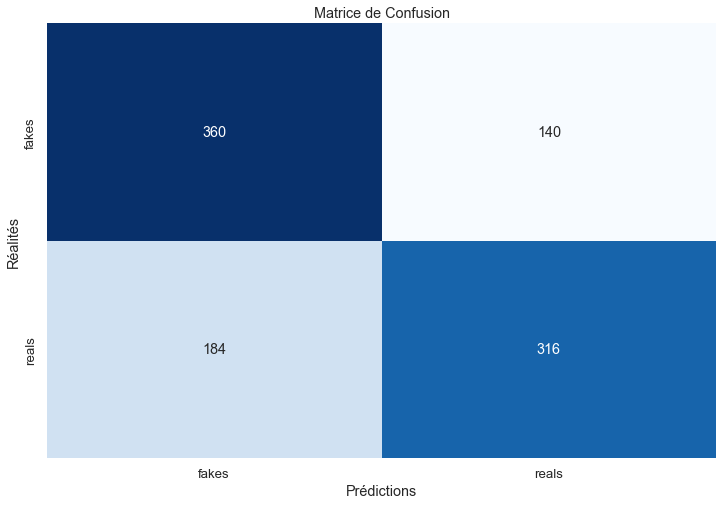

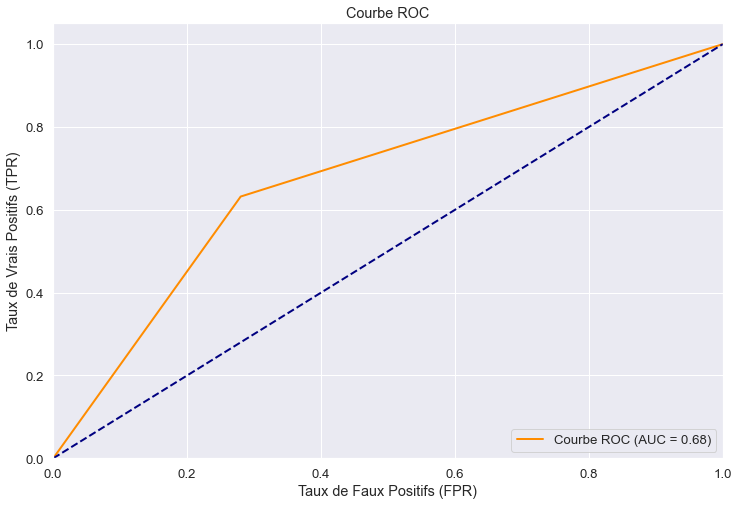

In [14]:
# Créez une liste d'estimateurs
estimators = [
    ('logistic_regression', LogisticRegression(random_state=random_state)),
    ('svc', SVC(random_state=random_state, probability=True)),
    ('multinomial_nb', MultinomialNB()),
    ('bernoulli_nb', BernoulliNB()),
    ('random_forest', RandomForestClassifier(random_state=random_state))
]

# Créez et entraînez le Voting Classifier en utilisant la liste d'estimateurs
voting_classifier = VotingClassifier(estimators=estimators, voting='soft').fit(X_trans, y)

# Utilisez le modèle pour faire des prédictions
y_pred = voting_classifier.predict(x_test_trans)

# Évaluez les performances du modèle
evaluate_classification(y_test, y_pred)